### Week 6 - Clean SWE analysis
Continuing work on SWE analysis workflow to move some of the code into functions

In [1]:
from osgeo import gdal
import matplotlib.pyplot as plt
import numpy as np
import rasterio as rio
from rasterio.plot import show
from rasterio.mask import mask
import pandas as pd
import fiona
import os
import glob
from scipy import sparse
%matplotlib inline

In [2]:
#Identify watershed by three letter acronymn and phase
wshed = "VAN"
phase = "P05"
subbasin= "Seymour"

#raster cell resolution
resolution = 1

name = wshed + "_" + str(phase)
subbasin_name = str(wshed + "_" + str(phase) + "_" + subbasin)
print("sub-basin: " + str(subbasin_name))
print("phase: " + str(phase))

#shapefile is the basin used to mask the rasters, should include the total lidar area if not a sub basin
basin = subbasin + ".shp"

#load in SWE multipliers and filter by watershed
SWE_2021 = pd.read_csv(r"H:\ACO Snow Blitz\SWE_multiplier_2021.csv")
SWE_2021 = SWE_2021[(SWE_2021['wshed'] == wshed)]
print(SWE_2021)

#File directories for all watersheds
BE_list = {"EGM" : r"H:\Englishman\2021\DEMs\bare_earth\EGM_BE_wgs84_1m.tif", 
      "VAN": r"H:\Metro-Van\2021\DEM\Baseline_Master_Dataset_WGS84\VAN_snowfree_merged_wgs84_utm10_itrf08_epoch2002_dz20cm_1mDEM.tif",
     "CRU" : r"H:\Cruickshank\2021\DEMs\Bare_earth\21_3011_00_snow_free_complete_utmz10_1mDEM.tif",
     "TSI": r"H:\Tsitika\2021\DEM\Bare_Earth\Tsitika_3m_Snow_Free_DTM_WGS84_z9_ellips.tif"}

aspect_list = {"EGM" : r"H:\Englishman\2021\GIS\aspect.tif", "VAN": r"H:\Metro-Van\2021\GIS\aspect.tif"}

snow_depth_list = {"EGM": r"H:\\Englishman\\2021\GIS\\snow_depth_rasters\\" + name + "_SD_clean.tif",
             "VAN": r"H:\\Metro-Van\\2021\GIS\\snow_depth_rasters\\" + name + "_warp.tif"}

basins = {"EGM": ["arrowsmith", "cokely", "fishtail"],"VAN": ["useymour_nolakes"]}
basin_directory = {"EGM": r"H:\Englishman\2021\GIS\boundaries", "VAN" : r"H:\Metro-Van\2021\GIS\wshed_boundaries"}

#swe table output for matrices
swe_table_list = {"EGM": r"H:\Englishman\2021\Analysis\swe_tables", "VAN": r"H:\Metro-Van\2021\Analysis\swe_tables"}
                   
basin = basins[wshed][0]
basin_fp = os.path.join(basin_directory[wshed],basin + ".shp")
print(basin_fp)


sub-basin: VAN_P05_Seymour
phase: P05
  wshed phase  l_ci  multiplier  h_ci
5   VAN   P01  0.40        0.40  0.40
6   VAN   P02  0.38        0.43  0.48
7   VAN   P03  0.48        0.50  0.53
8   VAN   P04  0.45        0.48  0.51
9   VAN   P05  0.51        0.55  0.59
H:\Metro-Van\2021\GIS\wshed_boundaries\useymour_nolakes.shp


In [3]:
#Calculate the multipliers, run function for low confidence interval, SWE muliplier, and high confidence interval
def SWE_multiply(parameter,phase):
    parameter = SWE_2021.loc[SWE_2021['phase'] == phase, parameter].item()
    return parameter

l_ci= SWE_multiply("l_ci", phase)
h_ci = SWE_multiply("h_ci", phase)
multiplier = SWE_multiply("multiplier", phase)

lm = l_ci/multiplier 
um = h_ci/multiplier

#Checks
print("Phase: " + str(name))
print("low CI: " + str(l_ci), str(lm))
print("high CI: " + str(h_ci), str(um))
print("multiplier: " + str(multiplier))

Phase: VAN_P05
low CI: 0.51 0.9272727272727272
high CI: 0.59 1.0727272727272725
multiplier: 0.55


In [4]:
#extract the cooridnates of the sub basin shapefile 
def coords (basin_directory):
    with fiona.open(basin_directory) as shapefile:
        print(shapefile)
        for feature in shapefile:
            shapes = [feature["geometry"]]
    return shapes

In [5]:
#call function - output should be paired coordinates
mask_coords = coords(basin_fp)
display(mask_coords)
type(mask_coords)

<open Collection 'H:\Metro-Van\2021\GIS\wshed_boundaries\useymour_nolakes.shp:useymour_nolakes', mode 'r' at 0x207cfe7dcf0>


[{'type': 'MultiPolygon',
  'coordinates': [[[(496979.0565999987, 5493253.833300001),
     (496971.0426999992, 5493249.438600001),
     (496963.02890000073, 5493254.0918000005),
     (496961.21929999976, 5493269.3439),
     (496965.8724999995, 5493277.874799999),
     (496967.94060000044, 5493283.562000001),
     (496962.25340000074, 5493289.5078),
     (496970.7841999992, 5493299.072699999),
     (496980.60759999865, 5493308.3791000005),
     (496988.62150000036, 5493317.426999998),
     (496989.65550000034, 5493323.631300001),
     (496999.2203999998, 5493335.005700001),
     (497009.3024000003, 5493334.488700001),
     (497014.73110000003, 5493323.1142),
     (497014.73110000003, 5493307.862099999),
     (497016.5406999988, 5493297.780200002),
     (497012.4045000012, 5493288.732299999),
     (497001.0300000008, 5493278.391799999),
     (496991.4650999991, 5493271.928999999),
     (496985.26080000063, 5493268.5684),
     (496984.74380000064, 5493259.003500001),
     (496979.05659999

list

In [1]:
#call function to mask the 
def open_masked_raster_array(tif):
    with rio.open(tif) as src:
        raster_image, raster_transform = rio.mask.mask(src, mask_coords, crop=True)
        raster_image = raster_image[0,:,:]
        raster_image.nodata = -999
        return raster_image

In [7]:
%%time
#mask the bare earth, check it displays
be_dem = open_masked_raster_array(BE_list[wshed])
be_dem = be_dem[0,:,:]
#no data value likey -3.40282...
display(be_dem)
display(be_dem.shape)
plt.imshow(be_dem)

array([[-9999., -9999., -9999., ..., -9999., -9999., -9999.],
       [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
       [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
       ...,
       [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
       [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
       [-9999., -9999., -9999., ..., -9999., -9999., -9999.]],
      dtype=float32)

(10393, 9096)

CPU times: total: 3.39 s
Wall time: 27.3 s


In [8]:
aspect = open_masked_raster_array(aspect_list[wshed])
aspect = aspect[0,:,:]
display(aspect)
display(aspect.shape)
plt.imshow(aspect)

array([[-3.4028235e+38, -3.4028235e+38, -3.4028235e+38, ...,
        -3.4028235e+38, -3.4028235e+38, -3.4028235e+38],
       [-3.4028235e+38, -3.4028235e+38, -3.4028235e+38, ...,
        -3.4028235e+38, -3.4028235e+38, -3.4028235e+38],
       [-3.4028235e+38, -3.4028235e+38, -3.4028235e+38, ...,
        -3.4028235e+38, -3.4028235e+38, -3.4028235e+38],
       ...,
       [-3.4028235e+38, -3.4028235e+38, -3.4028235e+38, ...,
        -3.4028235e+38, -3.4028235e+38, -3.4028235e+38],
       [-3.4028235e+38, -3.4028235e+38, -3.4028235e+38, ...,
        -3.4028235e+38, -3.4028235e+38, -3.4028235e+38],
       [-3.4028235e+38, -3.4028235e+38, -3.4028235e+38, ...,
        -3.4028235e+38, -3.4028235e+38, -3.4028235e+38]], dtype=float32)

(10393, 9096)

H:\\Metro-Van\\2021\GIS\\snow_depth_rasters\\VAN_P05_warp.tif


array([[-3.4028235e+38, -3.4028235e+38, -3.4028235e+38, ...,
        -3.4028235e+38, -3.4028235e+38, -3.4028235e+38],
       [-3.4028235e+38, -3.4028235e+38, -3.4028235e+38, ...,
        -3.4028235e+38, -3.4028235e+38, -3.4028235e+38],
       [-3.4028235e+38, -3.4028235e+38, -3.4028235e+38, ...,
        -3.4028235e+38, -3.4028235e+38, -3.4028235e+38],
       ...,
       [-3.4028235e+38, -3.4028235e+38, -3.4028235e+38, ...,
        -3.4028235e+38, -3.4028235e+38, -3.4028235e+38],
       [-3.4028235e+38, -3.4028235e+38, -3.4028235e+38, ...,
        -3.4028235e+38, -3.4028235e+38, -3.4028235e+38],
       [-3.4028235e+38, -3.4028235e+38, -3.4028235e+38, ...,
        -3.4028235e+38, -3.4028235e+38, -3.4028235e+38]], dtype=float32)

(10393, 9096)

CPU times: total: 2.05 s
Wall time: 53.9 s


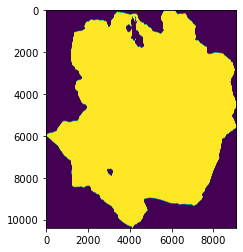

In [9]:
%%time
#mask the snow depth, check it displays
print(snow_depth_list[wshed])
snow_depth = open_masked_raster_array(snow_depth_list[wshed])
snow_depth = snow_depth[0,:,:]
#check the no data value, will be needed for next stage, could be -999
display(snow_depth)
display(snow_depth.shape)
plt.imshow(snow_depth)

In [10]:
#may need to change your no data value for the snow depth raster
#check that the shapes are the same
print("Bare earth,Snow depth, and aspect arrays the same size? " + str(be_dem.shape == snow_depth.shape == aspect.shape))

Bare earth,Snow depth, and aspect arrays the same size? True


In [11]:
aspect[be_dem < 0] = np.nan
snow_depth[be_dem < 0]= np.nan
be_dem[be_dem < 0] = np.nan

In [12]:
#unravel the rasters
be_dem_ravel = np.ravel(be_dem)
aspect_ravel = np.ravel(aspect)
snow_depth_ravel = np.ravel(snow_depth)

In [13]:
print("BAREEARTH:" + str(np.shape(be_dem_ravel)))
print("ASPECT:" + str(np.shape(aspect_ravel)))
print("SNOWDEPTH:" + str(np.shape(snow_depth_ravel)))

BAREEARTH:(94534728,)
ASPECT:(94534728,)
SNOWDEPTH:(94534728,)


In [14]:
#Convert the unravelled arrays into a data frame form
df = pd.DataFrame({"Elev": be_dem_ravel, "Asp": aspect_ravel, "SD": snow_depth_ravel})
#Change the no data values of snow depth and aspect to NP.nodata, then delete from DF
df['Asp'] = df['Asp'].map(lambda x: np.nan if x <-1  else x)
df['SD'] = df['SD'].map(lambda x: np.nan if x < -0.2  else x)
df = df.dropna()
df = df.reset_index(drop=True)
df['zbin'] = round(df["Elev"], -2)
df["asp"]= round(df["Asp"])
display(df)

Elev         Asp        SD    zbin    asp
0         1429.750000  319.610992  1.901245  1400.0  320.0
1         1430.159912  321.047058  1.920532  1400.0  321.0
2         1430.489990  326.492889  1.946777  1400.0  326.0
3         1430.609985  327.113159  2.140259  1400.0  327.0
4         1430.819946  329.111237  2.205811  1400.0  329.0
...               ...         ...       ...     ...    ...
61329386  1304.799927  252.588959  1.240356  1300.0  253.0
61329387  1304.839966  266.961731  1.255859  1300.0  267.0
61329388  1304.890015  266.902496  1.265625  1300.0  267.0
61329389  1304.959961  165.794769  1.191650  1300.0  166.0
61329390  1304.939941  190.137817  1.147827  1300.0  190.0

[61329391 rows x 5 columns]

In [15]:
#calc
def aspect(df, old_col, new_col):
    conditions_asp = [
        df[old_col] == -1,
        df[old_col] <= 22.5,
        df[old_col] <= 67.5,
        df[old_col] <= 112.5,
        df[old_col] <= 157.5,
        df[old_col] <= 202.5,
        df[old_col] <= 247.5,
        df[old_col] <= 292.5,
        df[old_col] <= 337.5,
        df[old_col] <= 360]

    values_asp = ["Flat", "North", "Northeast", "East", "Southeast", "South", "Southwest", "West", "Northwest", "North"]
    df[new_col] = np.select(conditions_asp, values_asp)

aspect(df, "Asp", "Aspect")

display(df)

Elev         Asp        SD    zbin    asp     Aspect
0         1429.750000  319.610992  1.901245  1400.0  320.0  Northwest
1         1430.159912  321.047058  1.920532  1400.0  321.0  Northwest
2         1430.489990  326.492889  1.946777  1400.0  326.0  Northwest
3         1430.609985  327.113159  2.140259  1400.0  327.0  Northwest
4         1430.819946  329.111237  2.205811  1400.0  329.0  Northwest
...               ...         ...       ...     ...    ...        ...
61329386  1304.799927  252.588959  1.240356  1300.0  253.0       West
61329387  1304.839966  266.961731  1.255859  1300.0  267.0       West
61329388  1304.890015  266.902496  1.265625  1300.0  267.0       West
61329389  1304.959961  165.794769  1.191650  1300.0  166.0      South
61329390  1304.939941  190.137817  1.147827  1300.0  190.0      South

[61329391 rows x 6 columns]

In [16]:
# Calculate swe and water volume based on the swe multiplier used, aswell as the raster resolution
display("SWE multiplier: " + str(multiplier))
display("Raster resolution: " + str(resolution))
#calculate columns for table
df["swe"]= df["SD"]*multiplier
df["swe_mm"]=df["swe"]*1000
df["swe_lm"]=(df["SD"]*l_ci)*1000
df["swe_hm"]=(df["SD"]*h_ci)*1000
df["water_vol"]= df["swe"]*(resolution*resolution)
df["lower_wv"]=df["water_vol"]*lm
df["upper_wv"]=df["water_vol"]*um
df["area"]= resolution


'SWE multiplier: 0.55'

'Raster resolution: 1'

In [17]:
#group by aspect, export avg stats
def aspect_group(parameter,subbasin_name,df, swe_table_list):
    asp_group = round(df.groupby(by=[parameter],as_index=True)[["swe_mm","swe_lm", "swe_hm","water_vol", "lower_wv", "upper_wv" ]].mean(),2)
    os.chdir(swe_table_list)
    asp_group.to_csv("all_aspect_"+ subbasin_name + ".csv")


aspect_group("asp",subbasin_name,df, swe_table_list[wshed])   

In [18]:
#Create dataframes for Average SWE by elevation and sum of water volume by elevation, parameter can be either zbin or aspect
def stats(parameter,subbasin_name,df,swe_table_list):
    avg_swe = round(df.groupby(by=[parameter],as_index=True)[["swe_mm","swe_lm", "swe_hm"]].mean(),2)
    avg_wv = round(df.groupby(by=[parameter],as_index=True)[["water_vol", "lower_wv", "upper_wv"]].sum(),2)
    merged=pd.concat([avg_swe,avg_wv],axis=1)
    merged["Phase"]= int(phase[2:])
    os.chdir(swe_table_list)
    merged.to_csv(parameter + "\\" + subbasin_name + "_" + parameter + "_stats.csv", index=True)

zbin = stats("zbin", subbasin_name, df,swe_table_list[wshed])
aspect = stats("Aspect", subbasin_name, df,swe_table_list[wshed])
asp = stats("asp", subbasin_name, df,swe_table_list[wshed])
                    

In [19]:
def pivot_table(value_col, agg_func,name, directory):
    output_name = subbasin_name +"_" + value_col + "_pivot.csv"
    sum = round(pd.crosstab(
      index=df['zbin'], columns=df['Aspect'],
      values=df[value_col], aggfunc=agg_func, margins=True,margins_name="Total").fillna(0),2)
    sum = sum[["Flat","North", "Northeast", "East", "Southeast", "South", "Southwest", "West", "Northwest","Total"]]
    display(sum)
    
    output = os.path.join(directory,output_name)
    sum.to_csv(output)


pivot = pivot_table("water_vol", "sum", name, swe_table_list[wshed])

Aspect  Flat       North   Northeast        East   Southeast       South  \
zbin                                                                       
200.0   0.00        0.00        0.00        0.00        0.00        0.00   
300.0   0.00        0.00        0.00        0.00        0.00        0.00   
400.0   0.00        0.00        0.00        0.00        0.00        0.00   
500.0   0.00        0.00        0.00        0.00        0.00        0.00   
600.0   0.00     4491.85     2842.41     4115.55     2942.33     1185.76   
700.0   0.00    32764.59    33427.11    29860.72    31167.05    26399.68   
800.0   0.00    77994.32   118696.51   107846.59    84135.92    83044.94   
900.0   0.00    99665.69   178387.60   194109.00   144815.95   125989.97   
1000.0  2.36   183379.68   287015.91   316190.38   287261.93   244227.42   
1100.0  3.50   381807.16   520227.30   511952.33   399302.72   316492.30   
1200.0  0.24   488728.50   646510.96   643518.74   421351.12   324979.08   
1300.0  0.00   495141.58   544437.81   658334.85   421228.28   297254.34   
1400.0  0.00   325608.68   264789.89   351298.18   294726.95   251428.34   
1500.0  0.00    70449.92    89319.70   126525.66   137831.78    90618.27   
1600.0  0.00    10815.41    15851.22    39542.39    53296.11    31856.42   
Total   6.10  2170847.38  2701506.42  2983294.39  2278060.12  1793476.54   

Aspect   Southwest        West   Northwest        Total  
zbin                                                     
200.0         0.00        0.00        0.00         0.00  
300.0         0.00        0.00        0.00         0.00  
400.0         0.00        0.00        0.00         0.00  
500.0         0.00        0.00        0.00         0.00  
600.0       282.21     2110.95     2062.14     20033.21  
700.0     11028.05     9043.86    18198.67    191889.73  
800.0     53763.97    47343.98    55067.93    627894.15  
900.0    114193.34   121491.84   100988.14   1079641.54  
1000.0   239292.73   273216.79   213964.52   2044551.73  
1100.0   337933.19   329325.44   335302.90   3132346.83  
1200.0   360504.77   411428.35   445570.28   3742592.03  
1300.0   402493.27   526981.24   566103.39   3911974.76  
1400.0   305309.10   438372.50   447898.39   2679432.02  
1500.0    98743.66   106654.00    84707.69    804850.69  
1600.0    20401.22    28401.20    21821.71    221985.68  
Total   1943945.50  2294370.15  2291685.76  18457192.36